In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import r2_score, mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

2023-04-19 10:24:15.442860: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('PPR-cleaned-v2.csv')
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df = df.set_index('Date')

/var/folders/55/j0v2zlbn1575rkmztsycxlfw0000gn/T/ipykernel_33889/1365018266.py:2: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)


## LSTM

In [3]:
def LSTM5yearpredict(county, town):
    df = pd.read_csv('PPR-cleaned-v2.csv')
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

    df = df.set_index('Date')

    # county = 'Carlow'
    # town = 'tullow'
    df = df.loc[(df['County'] == county) & (df['Town'] == town)]

    # prepare the data
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

    X_train, y_train = [], []
    for i in range(60, len(df)):
        X_train.append(df_scaled[i-60:i, 0])
        y_train.append(df_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # reshape the data for LSTM model
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # define the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))

    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # train the model
    model.fit(X_train, y_train, epochs=50, batch_size=32)

    # predict the next 5 years of property prices
    future_dates = pd.date_range(start=df.index[-1]+pd.DateOffset(years=1), periods=5, freq='YS')
    future_prices = []
    last_60_days = df_scaled[-60:]

    for i in range(5):
        input_data = last_60_days.reshape(1, -1, 1)
        prediction = model.predict(input_data)
        future_prices.append(prediction[0, 0])
        last_60_days = np.concatenate([last_60_days[1:], prediction], axis=0)

    future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))
    
    predicted = []
    dates = []

    # print the predicted prices
    for date, price in zip(future_dates, future_prices):
        #print(f"Predicted property price for {town}, {county} on {date}: €{price[0]:,.2f}")
        predicted.append(price[0])
        dates.append(date)
    return pd.to_datetime(dates),predicted

## Gradient Boost

In [4]:
def GB5yearpredict(county, town):
    df = pd.read_csv('PPR-cleaned-v2.csv')
    df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

    df = df.set_index('Date')

    # county = 'Carlow'
    # town = 'tullow'
    df = df.loc[(df['County'] == county) & (df['Town'] == town)]

    # prepare the data
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df['Price'].values.reshape(-1, 1))

    X_train, y_train = [], []
    for i in range(60, len(df)):
        X_train.append(df_scaled[i-60:i, 0])
        y_train.append(df_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)

    # train the model
    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0)
    model.fit(X_train, y_train)

    # predict the next 5 years of property prices
    future_dates = pd.date_range(start=df.index[-1]+pd.DateOffset(years=1), periods=5, freq='YS')
    future_prices = []
    last_60_days = df_scaled[-60:]

    for i in range(5):
        input_data = last_60_days.reshape(1, -1)
        prediction = model.predict(input_data)
        future_prices.append(prediction[0])
        last_60_days = np.concatenate([last_60_days[1:], prediction.reshape(1, -1)], axis=0)

    future_prices = scaler.inverse_transform(np.array(future_prices).reshape(-1, 1))
    
    predicted = []
    dates = []

    # print the predicted prices
    for date, price in zip(future_dates, future_prices):
        # print(f"Predicted property price for {town}, {county} on {date}: €{price[0]:,.2f}")
        dates.append(date)
        predicted.append(price[0])
    return pd.to_datetime(dates),predicted

In [5]:
lstmdates,lstmprices = LSTM5yearpredict('Dublin','dublin 1')
gbdates, gbprices = GB5yearpredict('Dublin','dublin 1')

/var/folders/55/j0v2zlbn1575rkmztsycxlfw0000gn/T/ipykernel_33889/3181265503.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
2023-04-19 10:24:23.598008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 10:24:23.600586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this mess

Epoch 1/50


2023-04-19 10:24:24.935590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 10:24:24.937861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 10:24:24.940070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

76/76 [==============================] - 14s 62ms/step - loss: 4.8913e-04
Epoch 2/50
76/76 [==============================] - 4s 58ms/step - loss: 4.7022e-04
Epoch 3/50
76/76 [==============================] - 4s 58ms/step - loss: 4.7081e-04
Epoch 4/50
76/76 [==============================] - 5s 61ms/step - loss: 4.7212e-04
Epoch 5/50
76/76 [==============================] - 6s 75ms/step - loss: 4.6994e-04
Epoch 6/50
76/76 [==============================] - 5s 59ms/step - loss: 4.6830e-04
Epoch 7/50
76/76 [==============================] - 7s 94ms/step - loss: 4.6906e-04
Epoch 8/50
76/76 [==============================] - 7s 85ms/step - loss: 4.6807e-04
Epoch 9/50
76/76 [==============================] - 7s 90ms/step - loss: 4.6958e-04
Epoch 10/50
76/76 [==============================] - 6s 75ms/step - loss: 4.6914e-04
Epoch 11/50
76/76 [==============================] - 5s 69ms/step - loss: 4.6878e-04
Epoch 12/50
76/76 [==============================] - 6s 73ms/step - loss: 4.6946e-04

2023-04-19 10:29:13.778982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-19 10:29:13.781355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-19 10:29:13.783576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 34ms/step


/var/folders/55/j0v2zlbn1575rkmztsycxlfw0000gn/T/ipykernel_33889/3575372769.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)


In [6]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=pd.to_datetime(lstmdates),
                         y=lstmprices,
                         mode='lines',
                         name='LSTM'))
fig.add_trace(go.Scatter(x=pd.to_datetime(gbdates),
                         y=gbprices,
                         mode='lines',
                         name='GB'))
fig.show()

## Decision Tree Regressor to determine feature rankings

In [9]:
df = pd.read_csv('PPR-cleaned-v2.csv')
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df = df.set_index('Date')

# Drop irrelevant columns
df = df.drop(['Not Full Market Price', 'VAT Exclusive', 'Description of Property'], axis=1)

# One-hot encode categorical variables
df = pd.get_dummies(df, columns=['Town', 'County', 'Province'],dtype='uint8')

# Split the data into training and testing sets
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a decision tree regressor model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Predict on the testing set and calculate mean squared error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Perform cross-validation to evaluate model performance
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print('Cross-validation scores:', cv_scores)
print('Mean Cross-validation score:', cv_scores.mean())

# Get the feature importances
importances = model.feature_importances_
features = df.columns
indices = np.argsort(importances)[::-1]
# plt.figure(figsize=(10, 6))
# sns.barplot(x=importances[indices], y=features[indices])
# plt.title('Feature Importance')
# plt.show()

# Sort the features by importance
# indices = importances.argsort()[::-1]



/var/folders/55/j0v2zlbn1575rkmztsycxlfw0000gn/T/ipykernel_33889/1377301797.py:2: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



Mean Squared Error: 414614962400.9346
Cross-validation scores: [0.06106143 0.13340066 0.06954306 0.02616029 0.02503348]
Mean Cross-validation score: 0.0630397869861498


In [10]:
# Print the feature rankings
print("Feature rankings:")
for f in range(X.shape[1]):
    print("%d. %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

Feature rankings:
1. County_Dublin (0.440385)
2. Town_dublin 4 (0.046164)
3. Town_dublin 6 (0.043692)
4. County_Wicklow (0.029311)
5. Town_dalkey (0.027982)
6. Town_blackrock (0.026901)
7. County_Kildare (0.019671)
8. Town_dublin 14 (0.013627)
9. Town_foxrock dublin 18 (0.013578)
10. County_Meath (0.012043)
11. Town_ballsbridge (0.011532)
12. Town_malahide (0.011487)
13. Town_sandycove (0.011075)
14. Town_foxrock (0.010825)
15. Town_killiney (0.010596)
16. Town_monkstown (0.009594)
17. County_Cork (0.009528)
18. Town_dun laoghaire (0.009383)
19. Town_drimnagh (0.009347)
20. Town_glenageary (0.009327)
21. Town_dublin 18 (0.009061)
22. Town_rathgar (0.008144)
23. Town_howth (0.007994)
24. Town_charlestown (0.006891)
25. Town_mount merrion (0.006009)
26. Town_dublin 6w (0.005959)
27. Town_greystones (0.005462)
28. Town_balbriggan (0.005082)
29. Town_ballsbridge dublin 4 (0.004636)
30. Town_leopardstown (0.004512)
31. Town_rathmines (0.004308)
32. Town_donnybrook (0.004167)
33. Town_ennisk

## ARIMA

In [11]:
# Load the data into a pandas dataframe
df = pd.read_csv('PPR-cleaned-v2.csv')

# Convert the Date column to a datetime object and set it as the index
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df = df.set_index('Date')

# Group the data by month and calculate the mean price for each month
df_monthly = df.resample('M').mean()

# Plot the monthly mean prices
plt.plot(df_monthly)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Split the data into training and test sets
train_size = int(len(df_monthly) * 0.8)
train, test = df_monthly.iloc[:train_size], df_monthly.iloc[train_size:]

# Fit the ARIMA model on the training data
model = ARIMA(train, order=(2, 1, 2))
model_fit = model.fit()

# Make predictions on the test data
predictions = model_fit.predict(start=len(train), end=len(df_monthly)-1, typ='levels')

# Calculate the root mean squared error (RMSE) of the predictions
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
print('RMSE:', rmse)

# Plot the predictions against the test data
plt.plot(test)
plt.plot(predictions, color='red')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Actual', 'Predicted'])
plt.show()

/var/folders/55/j0v2zlbn1575rkmztsycxlfw0000gn/T/ipykernel_33889/2749913046.py:5: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



TypeError: Could not convert churchtownnewcastle westsalthillportlawbuncranadublin 16cabraleixlipnew rosslucancarrigtwohillnenaghdunboynekerry pikenaasdalkeycarrigalineartanenaascabranavanashbourneclonakiltysandymountdublin 12clonsillaclondalkinmitchelstowncaherciveenrahenydundalkpalmerstownbalbrigganlucanstepasidefinglascastleknockdublin 3birrkilbegganbirrportumnadouglasashbourneterenureashtowncrosshavenoldcastlebandondublin 16ballincolligratoathcastletroylucantallaghtdublin 9mullingarsandymountclonsillalismorekinsalekellsedenderrysandyfordmaynoothcabradooradoylebraydroghedadublin 6douglasheadford rdtraleedublin 5letterkennystepasideclonsillamountmellickballinasloekanturkthurlesdublin 11rathkealemountrathdunfanaghytraleetubbercurrynewportbraymurroefernscrosshavenrathdowneyrathdowneydublin 15letterkennydundalkswordsdublin 8douglasclogherheadkillarneyglanmirewiltonnewbridgetempleogueashtownashbournedrimnaghdublin 7tallaghtathytullamorestillorganrahoonclifdenskerriesgoreyratoathkinsaledublin 13rochestowndrumcondradroghedaclonsillaclontarfletterkennycastleknockdublin 12mullingarportlaoisedublin 8monkstownknocklyonmalahidemonasterevindublin 16dublin 3dublin 9drumcondradublin 4dublin 14mullingarmalahidekilcooleturners crosskilcooleartanefinglasswordsswordsclonmeldublin 3blackrockclontarfdroghedamaynoothdublin 15cashelportlaoisekillarneyshankillblackrockcastleknockbraycarrigtwohillballyconnellcourtownballinasloeheadforddungarvandunmore eastennis rdmohillkilmacthomasballinasloeclanenaasjohnswell rdstrandhillmullingarmullingarcarndonaghheadfordkilcooleskerriesblarneydublin rdarklowsandyfordtullamoreskerriesballincolligdundrumdublin 24rathnewdungarvanmurroestillorgancastleknocklucankillarneydublin 15clanecarburyglasnevinrenmoremonaleendublin 7ashbournekilmallockdundrumclonmelkilleaghlucancorballycabinteelyshankillmulgannonblackrockdublin 4celbridgemalahidetallaghtrosslare strandnewbridgebunclodyarklowballaghaderreentraleeclonmelcallandundalkcahirthurlesportarlingtonachillmullingardouglasdroghedaclonsillatempleoguedublin 13kilcullendouglasdublin 14dublin 9dublin 8swordscelbridgecarrigalinecarrigtwohillmaynoothbruffdublin 7maynoothcharlevilleadamstownleixlipportlaoisecarrigtwohilldundalkluskmaynoothlehenaghbegcarrigalinedun laoghairemidletonkillucanmalahideletterkennylaytowndublin 11tallaghtballinteerathymalahidedundalkdundalkdublin 12knocklyondalkeyennistempleoguecrumlindungarvanannacottykillorglinnew rossportlaoisebalbriggankilkeeletterkennydublin 4trimmoycullenlucanmoatemalahideblackrockmaynoothnavanbundorankillineydublin 13mallowathloneballyshannontuambaltinglassrathangankillarneykillorglintraleekilmallockdalkeykillarneykinsalemountmellickportlaoisesandymountroscrearoscreafernslistowelnaasathyblackrocknaasnewbridgedublin 5dublin 3mullingarcloneedonabateswordsnewbridgenewbridgedublin 12barnafernscelbridgebrayleixlipdroghedatuamclonmeldouglasknocklyonnenaghenniscorthyshankilldublin 15tramorefermoydublin 6corballycastletroydublin 24crumlincarrigalinesummerhillrathminestallaghtdelganymallowdublin 24mallowkinsalenavanroscreacastleknockluskcelbridgedingletramorenewcastleraheenclonsillabelturbettraleeglanmirekilmallocksandycovekillarneyfinglasmullingartallaghtblanchardstownwestportdublin 15monasterevinrathfarnhammullaghkellsfernsnenaghmungretblackrockblackrockwiltonmonasterevinenfieldknocknacarrabrayballyvolanetogherdroghedacarrickminescabinteelyathloneballintemplecarrigalinetramorewalkinstownloughreadublin 24balbriggandrumcondradublin 9templeoguegreystonesashbournegreystonessaggarttempleoguebalbriggandublin 9killarneytramoresantrylaytowndelganyletterkennydublin 7passage westdublin 3terenureclanenewbridgeportlaoisestepasidenavancelbridgerathfarnhamglasnevindublin 8mullingardublin 24dungarvanleopardstownballycullentullowdublin 10loughreatullowoughterardcarrigtwohillranelaghknocklyonfinglaslongwooddublin 11bundoranblackrocktraleekilworthrathfarnhampassage westnewbridgeknocklyonblackrockdublin 4clontarfdublin 8rathangancootehillballyhauniskenmarekinsalekillarneykilmallockcraughwellrathfarnhamcastlecomercelbridgecarrigalinecastlebarportlaoisedooradoylestradballyfethardskerriesenniskerrypiltownloughreamullingarclaregalwayclaneleopardstownlucandublin 7rathcooletemplemoreclonmelrathfarnhamrahenyclonmelnaasballyfermotcarrigalinetermonfeckintrimroscamdublin 22midletonkillaloenenaghballincolligkillarneybalbriggancorballyclontarfmoatedrumcondracastleconnelldroghedablackrockthurlesmodel farm rdportlaoisemallowcarburynavanrosslareloughreamulgannonlistoweltraleevirginiasandycoveknocknacarrawestportcarrickmacrosswestportcarrickmacrossdundalkcloughjordanbagenalstowntullamorekillorglinkilkeeenfieldcastletroytramorelucanlusknewbridgerialtotraleeportlaoisedrumshanboglanmireroscreaballincolligkilkeeportlaoiseathloneclontarfrathgarleopardstowngoreyrushkillarneyfernstramoredublin 17droghedanewcastlewestbettystownletterkennydublin 15enniscashelkinsalestepasidedublin 15rahenynewcastlecrumlinennisovensnewcastle westcelbridgeballyjamesduffbettystownenfieldrathmoreballincollignenaghlistowelbaltimoredunleerenniscorthycashelmohillgoreyballincolliglistowelbantrynewmarketmohillnenaghdouglasdundrumashbournesalthillballymotemalahidecastletroygoreydublin 15adamstownblackrockclonsillatullowballinaghdublin 16dublin 7dungarvannaasdundalkleopardstowncarrickmacrossthomastownardeeshannonblackrockballincolligmullingarnaasgrangeknocklyongoreynewbridgedublin 18leixlipnenaghdublin 8crumlinenniscroneleixlipdrimnaghfermoynewcastle westfoxwooddungarvanadamstowndungarvanclonskeaghadamstownclondalkinbuncranaashbournedublin 11dublin 11castleknocksantryschulledenderrygoreytraleeclaremorriskillineyrathmineskinsaledromodboyleclondalkinnew rossadamstownnewmarket on fergusballsbridgesandymountdublin 15ardeedublin 24portlaoiseballyfermotdublin 24dublin 16tallaghtportlawdublin 12newportdublin 11blackrockrathangandublin 16tallaghtdundrumfoxrockdublin 9blackrockathyballinaghraheenmalahidemalahideblackrockmonkstownswordsmullingarashtownnaastullowmidletonnavanballybracktallaghtnewbridgerathnewmallowheadford rdbundoranloughreamalahidebalbriggandublin 22suttondunboynenenaghelphinmaynoothtraleeathenrypiltowntullamorecoolaneykinvaradouglasratoathkinsaleballymoterathminescarrigalineadamstowndroghedakillucanardeearklowashbourneclonmelnaasdublin 14tullamorebalbriggandublin 16kilcooledoneraileathenrycourtownmayfieldwalkinstownnavanlongwoodmilltownclonskeaghballincollignenaghliffordmurroekilbeggandublin 15douglasoranmorecarrigalineoranmorekillineydundalknaasmullingarskerriesgoreydouglasathlonedublin 13swordsnew rossnew rossportmarnockrathfarnhamterenurebalbrigganartanecloynecharlevilleenniscorthyschullcraughwellcootehillmullingarkinvaraballinasloerochestownnavanglasnevinballinteerkillarneymalahideknocklyonnaasballincolligenniscorthytraleerushroscreamitchelstowncobhyoughalcastleknockswordsfermoyblanchardstowndublin 15dundrumbrayranelaghstepasideoughterardportarlingtongreystonescarndonaghcastleislandschullkillarneygoreyrochestowndundalkcork cityrathangansummerhillashbournewatervillecabinteelyrathdowneyglanmirecabinteelynewbridgerathcooleaughrimstillorganfinglasgoreyblackrockballyconnelldublin 11balbriggandublin 3castletroyballsbridgeashbournelucanmullingarovensblanchardstownletterkennysaggartswordsdublin 12glanmirenavandroghedamountmellickknocklyoncelbridgerathfarnhamashtownbrayportlaoiseabbeyleixdublin 15dublin 15skerriesdublin 24mullaghnavangreystonesknocklyondublin 24mallowennisdublin 7lucanportlaoisestepasideclonsillacarrigalinerathfarnhamclondalkinathloneknocknacarrastepasidecabinteelytempleoguefinglasbantrysandyfordstamullenstamullennaasswordscabrablackrockleixlipbantrydublin 15adamstownglenagearymalahidetullamorebalbriggantallaghtdinglelucannaasrooskeydublin 13mountmellickenniscloneebraybraycarrigtwohilldundalkkilcullencelbridgejohnswell rdashbournebraysandymountrushgoreyballyhaunisrushrathfarnhamrosslarecappoquinnew rossswinfordkenmarecastletownberedundrumballinafernskellscahirmullingarmullingarathenryrahenykillorglinmallowmullingarglanmiredublin 9droghedatullowdooradoyleathloneknocklyonsuttonnewcastlewestdouglasglanmiremountmellickdunleerbraytempleogueblessingtonnewbridgeennismullingarcastleknocklucanbalgriffindublin 3dublin 12dublin 7artanekilmallockportlaoiseballybunionkillaloeheadfordbirrdouglasdrumcondrarathfarnhamblackrockdouglascobhnavanmalahidedublin 15dublin 14dublin 13waterford cityedgeworthstowncarrigtwohilldublin 6kilcooleblackrockcharlestownnewcastlefinglasdundalknenaghchurchtowntullowdundalkdroghedanavandublin 18midletonglasnevindonerailecastleblayneynewportclaregalwaytemplemorekellskellscoolaneytemplemoreedgeworthstownloughreaathykilmallockkilmallockkilmallockgoreylucanmaynoothrochestowncrumlindublin 9knocknacarrapiltowngraiguecullendrumcondraballinasloefinglasblackrockmidletonashtowncelbridgesantryportmarnockdublin 15trimtullamorehowthdublin 11clondalkinashtownwatergrasshilldouglasmalahideballinteercrumlindublin 12dublin 4delvinabbeyfealebrufftuamdingleblackwaternavanrathanganadarewestportnenaghcarrickmacrossdunboynebalbrigganartanedublin 5sandyforddublin 6wdunboynedublin 11rushdublin 6wshankilldublin 22tullowdublin 14nenaghlucanswordsdublin 7dublin rdslanedublin 3dublin 13clontarfchurchtownclontarfletterkennyadamstownsandyfordlucandublin 12howthportlaoisedonabatenavandublin 11thomastowntraleeblackpoolathboymidletoncarrickmacrossletterkennykilmallocksandymountclonmelkillineyclonmelblackrockballinaghdublin 15leixlipdalkeytallaghtmalahiderochestownnewbridgetullamoreroscamglasnevindublin 12balgriffincobhbooterstownadamstownterenurebalbrigganstillorganenniscorthycarrigalineballinteercarrickmacrosstallaghtgreystonesswordsdublin 15swordsdublin 4dublin 24dublin 8balbrigganenniscorthyskerriesblanchardstowndublin 3dublin 9santryportarlingtonshankilldalkeynenaghlucandublin 15santrykillmonkstowntuamlucankilkeeclonskeaghcastleblayneydublin 22tullamoreclanedublin 12duleektrimsantrydrimnaghdrumcondracourtowncarrigtwohilldublin 24traleemulgannoncarrickminesswordstrimrathkealemullingarroscreaenniscorthyskerriestraleelaytownlaytownlaytownkillarneyballyhaunisrosslare strandennisathytrimdroghedamacroomsandycovemullingarballyshannonportmarnockcastletroy to numeric

## SARIMAX

In [12]:
# Load the data into a pandas dataframe
df = pd.read_csv('PPR-cleaned-v2.csv')
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df = df.set_index('Date')

# Group the data by month and calculate the mean price
df_monthly = df.resample('MS').mean()

# Split the data into training and testing sets
train = df_monthly.loc[:'2021-06-01', 'Price']
test = df_monthly.loc['2021-07-01':, 'Price']

# Fit the SARIMA model to the training data
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), enforce_invertibility=False)
results = model.fit()

# Generate predictions for the test data
predictions = results.predict(start='2022-07-01', end='2028-04-01', dynamic=True)

# Plot the actual and predicted values
plt.plot(train.index, train, label='Training')
plt.plot(test.index, test, label='Actual')
plt.plot(predictions.index, predictions, label='Predicted')
plt.legend()
plt.show()

/var/folders/55/j0v2zlbn1575rkmztsycxlfw0000gn/T/ipykernel_33889/4251257049.py:3: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



TypeError: Could not convert churchtownnewcastle westsalthillportlawbuncranadublin 16cabraleixlipnew rosslucancarrigtwohillnenaghdunboynekerry pikenaasdalkeycarrigalineartanenaascabranavanashbourneclonakiltysandymountdublin 12clonsillaclondalkinmitchelstowncaherciveenrahenydundalkpalmerstownbalbrigganlucanstepasidefinglascastleknockdublin 3birrkilbegganbirrportumnadouglasashbourneterenureashtowncrosshavenoldcastlebandondublin 16ballincolligratoathcastletroylucantallaghtdublin 9mullingarsandymountclonsillalismorekinsalekellsedenderrysandyfordmaynoothcabradooradoylebraydroghedadublin 6douglasheadford rdtraleedublin 5letterkennystepasideclonsillamountmellickballinasloekanturkthurlesdublin 11rathkealemountrathdunfanaghytraleetubbercurrynewportbraymurroefernscrosshavenrathdowneyrathdowneydublin 15letterkennydundalkswordsdublin 8douglasclogherheadkillarneyglanmirewiltonnewbridgetempleogueashtownashbournedrimnaghdublin 7tallaghtathytullamorestillorganrahoonclifdenskerriesgoreyratoathkinsaledublin 13rochestowndrumcondradroghedaclonsillaclontarfletterkennycastleknockdublin 12mullingarportlaoisedublin 8monkstownknocklyonmalahidemonasterevindublin 16dublin 3dublin 9drumcondradublin 4dublin 14mullingarmalahidekilcooleturners crosskilcooleartanefinglasswordsswordsclonmeldublin 3blackrockclontarfdroghedamaynoothdublin 15cashelportlaoisekillarneyshankillblackrockcastleknockbraycarrigtwohillballyconnellcourtownballinasloeheadforddungarvandunmore eastennis rdmohillkilmacthomasballinasloeclanenaasjohnswell rdstrandhillmullingarmullingarcarndonaghheadfordkilcooleskerriesblarneydublin rdarklowsandyfordtullamoreskerriesballincolligdundrumdublin 24rathnewdungarvanmurroestillorgancastleknocklucankillarneydublin 15clanecarburyglasnevinrenmoremonaleendublin 7ashbournekilmallockdundrumclonmelkilleaghlucancorballycabinteelyshankillmulgannonblackrockdublin 4celbridgemalahidetallaghtrosslare strandnewbridgebunclodyarklowballaghaderreentraleeclonmelcallandundalkcahirthurlesportarlingtonachillmullingardouglasdroghedaclonsillatempleoguedublin 13kilcullendouglasdublin 14dublin 9dublin 8swordscelbridgecarrigalinecarrigtwohillmaynoothbruffdublin 7maynoothcharlevilleadamstownleixlipportlaoisecarrigtwohilldundalkluskmaynoothlehenaghbegcarrigalinedun laoghairemidletonkillucanmalahideletterkennylaytowndublin 11tallaghtballinteerathymalahidedundalkdundalkdublin 12knocklyondalkeyennistempleoguecrumlindungarvanannacottykillorglinnew rossportlaoisebalbriggankilkeeletterkennydublin 4trimmoycullenlucanmoatemalahideblackrockmaynoothnavanbundorankillineydublin 13mallowathloneballyshannontuambaltinglassrathangankillarneykillorglintraleekilmallockdalkeykillarneykinsalemountmellickportlaoisesandymountroscrearoscreafernslistowelnaasathyblackrocknaasnewbridgedublin 5dublin 3mullingarcloneedonabateswordsnewbridgenewbridgedublin 12barnafernscelbridgebrayleixlipdroghedatuamclonmeldouglasknocklyonnenaghenniscorthyshankilldublin 15tramorefermoydublin 6corballycastletroydublin 24crumlincarrigalinesummerhillrathminestallaghtdelganymallowdublin 24mallowkinsalenavanroscreacastleknockluskcelbridgedingletramorenewcastleraheenclonsillabelturbettraleeglanmirekilmallocksandycovekillarneyfinglasmullingartallaghtblanchardstownwestportdublin 15monasterevinrathfarnhammullaghkellsfernsnenaghmungretblackrockblackrockwiltonmonasterevinenfieldknocknacarrabrayballyvolanetogherdroghedacarrickminescabinteelyathloneballintemplecarrigalinetramorewalkinstownloughreadublin 24balbriggandrumcondradublin 9templeoguegreystonesashbournegreystonessaggarttempleoguebalbriggandublin 9killarneytramoresantrylaytowndelganyletterkennydublin 7passage westdublin 3terenureclanenewbridgeportlaoisestepasidenavancelbridgerathfarnhamglasnevindublin 8mullingardublin 24dungarvanleopardstownballycullentullowdublin 10loughreatullowoughterardcarrigtwohillranelaghknocklyonfinglaslongwooddublin 11bundoranblackrocktraleekilworthrathfarnhampassage westnewbridgeknocklyonblackrockdublin 4clontarfdublin 8rathangancootehillballyhauniskenmarekinsalekillarneykilmallockcraughwellrathfarnhamcastlecomercelbridgecarrigalinecastlebarportlaoisedooradoylestradballyfethardskerriesenniskerrypiltownloughreamullingarclaregalwayclaneleopardstownlucandublin 7rathcooletemplemoreclonmelrathfarnhamrahenyclonmelnaasballyfermotcarrigalinetermonfeckintrimroscamdublin 22midletonkillaloenenaghballincolligkillarneybalbriggancorballyclontarfmoatedrumcondracastleconnelldroghedablackrockthurlesmodel farm rdportlaoisemallowcarburynavanrosslareloughreamulgannonlistoweltraleevirginiasandycoveknocknacarrawestportcarrickmacrosswestportcarrickmacrossdundalkcloughjordanbagenalstowntullamorekillorglinkilkeeenfieldcastletroytramorelucanlusknewbridgerialtotraleeportlaoisedrumshanboglanmireroscreaballincolligkilkeeportlaoiseathloneclontarfrathgarleopardstowngoreyrushkillarneyfernstramoredublin 17droghedanewcastlewestbettystownletterkennydublin 15enniscashelkinsalestepasidedublin 15rahenynewcastlecrumlinennisovensnewcastle westcelbridgeballyjamesduffbettystownenfieldrathmoreballincollignenaghlistowelbaltimoredunleerenniscorthycashelmohillgoreyballincolliglistowelbantrynewmarketmohillnenaghdouglasdundrumashbournesalthillballymotemalahidecastletroygoreydublin 15adamstownblackrockclonsillatullowballinaghdublin 16dublin 7dungarvannaasdundalkleopardstowncarrickmacrossthomastownardeeshannonblackrockballincolligmullingarnaasgrangeknocklyongoreynewbridgedublin 18leixlipnenaghdublin 8crumlinenniscroneleixlipdrimnaghfermoynewcastle westfoxwooddungarvanadamstowndungarvanclonskeaghadamstownclondalkinbuncranaashbournedublin 11dublin 11castleknocksantryschulledenderrygoreytraleeclaremorriskillineyrathmineskinsaledromodboyleclondalkinnew rossadamstownnewmarket on fergusballsbridgesandymountdublin 15ardeedublin 24portlaoiseballyfermotdublin 24dublin 16tallaghtportlawdublin 12newportdublin 11blackrockrathangandublin 16tallaghtdundrumfoxrockdublin 9blackrockathyballinaghraheenmalahidemalahideblackrockmonkstownswordsmullingarashtownnaastullowmidletonnavanballybracktallaghtnewbridgerathnewmallowheadford rdbundoranloughreamalahidebalbriggandublin 22suttondunboynenenaghelphinmaynoothtraleeathenrypiltowntullamorecoolaneykinvaradouglasratoathkinsaleballymoterathminescarrigalineadamstowndroghedakillucanardeearklowashbourneclonmelnaasdublin 14tullamorebalbriggandublin 16kilcooledoneraileathenrycourtownmayfieldwalkinstownnavanlongwoodmilltownclonskeaghballincollignenaghliffordmurroekilbeggandublin 15douglasoranmorecarrigalineoranmorekillineydundalknaasmullingarskerriesgoreydouglasathlonedublin 13swordsnew rossnew rossportmarnockrathfarnhamterenurebalbrigganartanecloynecharlevilleenniscorthyschullcraughwellcootehillmullingarkinvaraballinasloerochestownnavanglasnevinballinteerkillarneymalahideknocklyonnaasballincolligenniscorthytraleerushroscreamitchelstowncobhyoughalcastleknockswordsfermoyblanchardstowndublin 15dundrumbrayranelaghstepasideoughterardportarlingtongreystonescarndonaghcastleislandschullkillarneygoreyrochestowndundalkcork cityrathangansummerhillashbournewatervillecabinteelyrathdowneyglanmirecabinteelynewbridgerathcooleaughrimstillorganfinglasgoreyblackrockballyconnelldublin 11balbriggandublin 3castletroyballsbridgeashbournelucanmullingarovensblanchardstownletterkennysaggartswordsdublin 12glanmirenavandroghedamountmellickknocklyoncelbridgerathfarnhamashtownbrayportlaoiseabbeyleixdublin 15dublin 15skerriesdublin 24mullaghnavangreystonesknocklyondublin 24mallowennisdublin 7lucanportlaoisestepasideclonsillacarrigalinerathfarnhamclondalkinathloneknocknacarrastepasidecabinteelytempleoguefinglasbantrysandyfordstamullenstamullennaasswordscabrablackrockleixlipbantrydublin 15adamstownglenagearymalahidetullamorebalbriggantallaghtdinglelucannaasrooskeydublin 13mountmellickenniscloneebraybraycarrigtwohilldundalkkilcullencelbridgejohnswell rdashbournebraysandymountrushgoreyballyhaunisrushrathfarnhamrosslarecappoquinnew rossswinfordkenmarecastletownberedundrumballinafernskellscahirmullingarmullingarathenryrahenykillorglinmallowmullingarglanmiredublin 9droghedatullowdooradoyleathloneknocklyonsuttonnewcastlewestdouglasglanmiremountmellickdunleerbraytempleogueblessingtonnewbridgeennismullingarcastleknocklucanbalgriffindublin 3dublin 12dublin 7artanekilmallockportlaoiseballybunionkillaloeheadfordbirrdouglasdrumcondrarathfarnhamblackrockdouglascobhnavanmalahidedublin 15dublin 14dublin 13waterford cityedgeworthstowncarrigtwohilldublin 6kilcooleblackrockcharlestownnewcastlefinglasdundalknenaghchurchtowntullowdundalkdroghedanavandublin 18midletonglasnevindonerailecastleblayneynewportclaregalwaytemplemorekellskellscoolaneytemplemoreedgeworthstownloughreaathykilmallockkilmallockkilmallockgoreylucanmaynoothrochestowncrumlindublin 9knocknacarrapiltowngraiguecullendrumcondraballinasloefinglasblackrockmidletonashtowncelbridgesantryportmarnockdublin 15trimtullamorehowthdublin 11clondalkinashtownwatergrasshilldouglasmalahideballinteercrumlindublin 12dublin 4delvinabbeyfealebrufftuamdingleblackwaternavanrathanganadarewestportnenaghcarrickmacrossdunboynebalbrigganartanedublin 5sandyforddublin 6wdunboynedublin 11rushdublin 6wshankilldublin 22tullowdublin 14nenaghlucanswordsdublin 7dublin rdslanedublin 3dublin 13clontarfchurchtownclontarfletterkennyadamstownsandyfordlucandublin 12howthportlaoisedonabatenavandublin 11thomastowntraleeblackpoolathboymidletoncarrickmacrossletterkennykilmallocksandymountclonmelkillineyclonmelblackrockballinaghdublin 15leixlipdalkeytallaghtmalahiderochestownnewbridgetullamoreroscamglasnevindublin 12balgriffincobhbooterstownadamstownterenurebalbrigganstillorganenniscorthycarrigalineballinteercarrickmacrosstallaghtgreystonesswordsdublin 15swordsdublin 4dublin 24dublin 8balbrigganenniscorthyskerriesblanchardstowndublin 3dublin 9santryportarlingtonshankilldalkeynenaghlucandublin 15santrykillmonkstowntuamlucankilkeeclonskeaghcastleblayneydublin 22tullamoreclanedublin 12duleektrimsantrydrimnaghdrumcondracourtowncarrigtwohilldublin 24traleemulgannoncarrickminesswordstrimrathkealemullingarroscreaenniscorthyskerriestraleelaytownlaytownlaytownkillarneyballyhaunisrosslare strandennisathytrimdroghedamacroomsandycovemullingarballyshannonportmarnockcastletroy to numeric

## Linear Regression

In [13]:
# Load the data and select relevant columns
df = pd.read_csv('PPR-cleaned-v2.csv')
df = df[['Price', 'County', 'Description of Property', 'Province']]

# Handle missing values and outliers
df = df.dropna() # Drop rows with missing values
df = df[df['Price'] > 0] # Remove rows with zero or negative prices
df = df[df['Price'] < np.percentile(df['Price'], 99)] # Remove top 1% of prices as outliers

# Encode categorical variables using one-hot encoding
df = pd.get_dummies(df, columns=['County', 'Description of Property', 'Province'])

# Split the data into training and test sets
X = df.drop('Price', axis=1)
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the numerical variables using standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the linear regression model on the training set
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Evaluate the model's performance on the test set
y_pred = lr.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean squared error: {mse:.2f}')
print(f'R-squared: {r2:.2f}')

Mean squared error: 25498862956.32
R-squared: 0.26


## Random Forest with CV

In [ ]:
# Load the data into a pandas dataframe
df = pd.read_csv('PPR-cleaned-v2.csv')
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df = df.set_index('Date')

# Select the relevant columns for modeling
X = df[['County', 'Description of Property','Not Full Market Price', 'VAT Exclusive']].copy()

# One-hot encode categorical variables
X = pd.get_dummies(X, columns=['County', 'Description of Property','Not Full Market Price', 'VAT Exclusive'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, df['Price'], test_size=0.2, random_state=42)

# Create and fit the random forest model with 1000 trees
rf = RandomForestRegressor(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

# Predict on the testing set and calculate mean squared error
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error:', mse)

# Perform cross-validation to evaluate model performance
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
print('Cross-validation scores:', cv_scores)
print('Mean Cross-validation score:', cv_scores.mean())

# Plot feature importance
importances = rf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=features[indices])
plt.title('Feature Importance')
plt.show()


Mean Squared Error: 429056525806.9717


KeyboardInterrupt: 

## KMeans

/var/folders/55/j0v2zlbn1575rkmztsycxlfw0000gn/T/ipykernel_33889/3266486803.py:2: UserWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

/Users/pratik/opt/miniconda3/envs/SETU/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



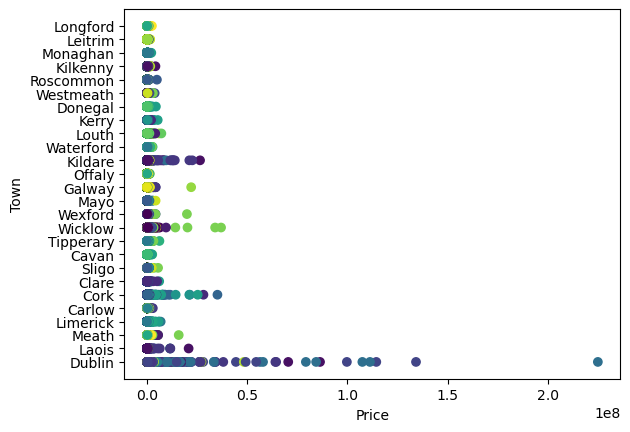

In [14]:
df = pd.read_csv('PPR-cleaned-v2.csv')
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df = df.set_index('Date')

# Select the relevant columns for clustering
X = df[['Town', 'County', 'Description of Property', 'Province']].copy()

# Use LabelEncoder to convert categorical columns to numerical values
le = LabelEncoder()
X['Town'] = le.fit_transform(X['Town'])
X['County'] = le.fit_transform(X['County'])
X['Description of Property'] = le.fit_transform(X['Description of Property'])
X['Province'] = le.fit_transform(X['Province'])

# Scale the data to have zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Set the number of clusters and fit the K-means model
kmeans = KMeans(n_clusters=26, random_state=42)
kmeans.fit(X_scaled)

# Get the cluster labels and add them to the original dataframe
labels = kmeans.labels_
df['Cluster'] = labels

# Plot the clusters on a scatterplot
plt.scatter(df['Price'], df['County'], c=labels)
plt.xlabel('Price')
plt.ylabel('Town')
plt.show()

## Prophet

In [ ]:
from fbprophet import Prophet

# Prepare data
df = pd.read_csv('PPR-cleaned-v2.csv')
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df = df.set_index('Date')
df = df.resample('M').mean() # Resample to monthly data
df = df.reset_index()
df = df[['Date', 'Price']]

# Prepare data for Prophet model
df_prophet = df.rename(columns={'Date':'ds', 'Price':'y'})

# Fit Prophet model
m = Prophet()
m.fit(df_prophet)

# Make future predictions
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

# Plot forecast
m.plot(forecast)

ModuleNotFoundError: No module named 'fbprophet'